## Importing Libraries

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

## Loading and Inspecting Data

In [35]:


# converting TIMESTAMP to Year, Month, Day, and Hour columns
def convert_timestamp(df):
    df['Year'] = df['TIMESTAMP'].str[:4]
    df['Month'] = df['TIMESTAMP'].str[4:6]
    df['Day'] = df['TIMESTAMP'].str[6:8]
    df['Hour'] = df['TIMESTAMP'].str[9:11]
    return df

# Import Training Data
TrainData = pd.read_csv("TrainData_B.csv")


# calling function to convert TIMESTAMP
TrainData = convert_timestamp(TrainData)
#checking data
print(TrainData.head())

        TIMESTAMP     POWER      U10      V10      U100     V100  Year Month  \
0  20150101 00:00       NaN      NaN      NaN       NaN      NaN  2015    01   
1  20150101 01:00       NaN  6.24102  3.49613   9.73707  4.78492  2015    01   
2  20150101 02:00       NaN  5.62234  4.06239   8.94497  5.71768  2015    01   
3  20150101 03:00  0.666693  5.99531  4.89334   9.52143  6.99094  2015    01   
4  20150101 04:00       NaN  6.90809  4.79099  10.63280  6.75417  2015    01   

  Day Hour  
0  01   00  
1  01   01  
2  01   02  
3  01   03  
4  01   04  


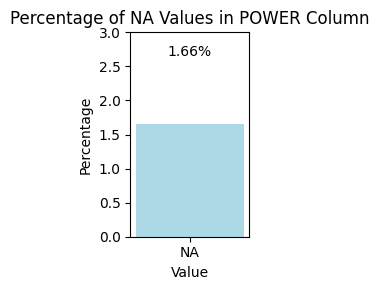

In [36]:
# Count the frequency of 'NA' values in the 'POWER' column and calculate percentage
na_frequency = TrainData['POWER'].isna().sum()
total_entries = len(TrainData)
na_percentage = (na_frequency / total_entries) * 100

# plotting the percentage of 'NA' values in 'Power' column
plt.figure(figsize=(2, 3))
plt.bar(['NA'], [na_percentage], color='lightblue')
plt.title('Percentage of NA Values in POWER Column')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.ylim(0, 3)
plt.text(x=0, y=na_percentage + 1, s=f'{na_percentage:.2f}%', ha='center')
plt.tight_layout()
plt.show()



In [37]:
#In order to replace NA values, we calculate median for Power in each Month Year combination, to replace it in those times with NA
# Step 1: Group by Month and Year, calculate the median for POWER
df_median = TrainData.groupby(['Month', 'Year'])['POWER'].median().reset_index()
df_median.columns = ['Month', 'Year', 'median_power']

# Step 2: Merge the median values back to the original DataFrame
TrainData = pd.merge(TrainData, df_median, on=['Month', 'Year'], how='left')

# Step 3: Fill NA values in POWER with linearly interpolated values
TrainData['POWER'] = TrainData['POWER'].fillna(TrainData['median_power'])

# Step 4: Drop the auxiliary column
TrainData.drop(columns=['median_power'], inplace=True)

# Now TrainData contains the DataFrame with NAs in the POWER column replaced by the median for that Month and Year


In [38]:
# Remove the rows with NA values that are left
TrainData.dropna(inplace=True)

## Feature Engineering

In [39]:
#Features to study to check
#wind direction in degrees
def calculate_wind_direction(df):
    df['WindDir_10m'] = np.degrees(np.arctan2(df['V10'], df['U10'])) % 360
    df['WindDir_100m'] = np.degrees(np.arctan2(df['V100'], df['U100'])) % 360
    return df
#windspeed magnitude
def calculate_velocity_magnitude(df):
    df['VelMag_10m'] = np.sqrt(df['U10'] ** 2 + df['V10'] ** 2)
    df['VelMag_100m'] = np.sqrt(df['U100'] ** 2 + df['V100'] ** 2)
    return df
#cubic power of windspeed
def add_cubic_power(df):
    df['VelMagCub_10m'] = df['VelMag_10m'] ** 3
    df['VelMagCub_100m'] = df['VelMag_100m'] ** 3
    return df
#Windspeed difference
def add_wind_speed_difference(df):
    df['WS_Diff_10m'] = df['VelMag_10m'].diff().fillna(df['VelMag_10m'].iloc[1])
    df['WS_Diff_100m'] = df['VelMag_100m'].diff().fillna(df['VelMag_100m'].iloc[1])
    return df
#acceleration
def add_acceleration(df):
    df['Accel_U10'] = df['U10'].diff() / 3600  # 1 hour in seconds
    df['Accel_V10'] = df['V10'].diff() / 3600  # 1 hour in seconds
    df['Accel_U100'] = df['U100'].diff() / 3600  # 1 hour in seconds
    df['Accel_V100'] = df['V100'].diff() / 3600  # 1 hour in seconds
    
    # Fill first acceleration value with the second acceleration value
    df['Accel_U10'].iloc[0] = df['Accel_U10'].iloc[1]
    df['Accel_V10'].iloc[0] = df['Accel_V10'].iloc[1]
    df['Accel_U100'].iloc[0] = df['Accel_U100'].iloc[1]
    df['Accel_V100'].iloc[0] = df['Accel_V100'].iloc[1]
    
    return df
#velocity lag (value of velocity in the previous hour)
def add_lag(train_data_A):
    # Define the number of lag steps
    lag_steps = 1 

    # Creation of lag features for U10, U100, V10, and V100
    for feature in ['U10', 'U100', 'V10', 'V100']:
        for i in range(1, lag_steps + 1):
            # lag values
            train_data_A[f'{feature}lag{i}'] = train_data_A[feature].shift(i)

    # Drop rows with NaN values resulting from the lag operation (This will only drop the first row)
    train_data_A.dropna(inplace=True)
    return train_data_A



In [40]:
#Add all the features to our TrainData
TrainData = calculate_wind_direction(TrainData)
TrainData = calculate_velocity_magnitude(TrainData)
TrainData = add_cubic_power(TrainData)
TrainData = add_wind_speed_difference(TrainData)
TrainData = add_acceleration(TrainData)
TrainData= add_lag(TrainData)
print(TrainData)

            TIMESTAMP     POWER      U10      V10      U100     V100  Year  \
2      20150101 02:00  0.754524  5.62234  4.06239   8.94497  5.71768  2015   
3      20150101 03:00  0.666693  5.99531  4.89334   9.52143  6.99094  2015   
4      20150101 04:00  0.754524  6.90809  4.79099  10.63280  6.75417  2015   
5      20150101 05:00  0.754524  6.95268  4.83204  10.70080  6.74193  2015   
6      20150101 06:00  0.937501  6.17865  5.70277   9.73491  8.09731  2015   
...               ...       ...      ...      ...       ...      ...   ...   
27715  20180228 19:00  0.745281 -9.08527 -1.71610 -11.98790 -1.93709  2018   
27716  20180228 20:00  0.666377 -9.77183 -0.99013 -12.93450 -1.09401  2018   
27717  20180228 21:00  0.665494 -9.93655 -1.46134 -13.15290 -1.64132  2018   
27718  20180228 22:00  0.740842 -9.64931 -1.66024 -12.78580 -1.87863  2018   
27719  20180228 23:00  0.699803 -9.38556 -1.69723 -12.41550 -1.95747  2018   

      Month Day Hour  ...  WS_Diff_10m  WS_Diff_100m  Accel_U10

C:\Users\jihad\AppData\Local\Temp\ipykernel_14304\1713920562.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Accel_U10'].iloc[0] = df['Accel_U10'].iloc[1]
C:\Users\jihad\AppData\Local\Temp\ipykernel_14304\1713920562.py:30: SettingWi

In [41]:
#based on the terrain in the Horns Rev Farm, we will approximate Hellmann's constant with 0.125
#calculate velocity at different heights using Hellmann's formula
def calculate_velocity_at_heights(df):
    heights = [20, 30, 40, 50, 60, 70, 80, 90]
    
    for height in heights:
        new_column_name = f'VelMag_{height}m'
        df[new_column_name] = df['VelMag_10m'] * (height / 10) ** 0.125
    
    return df

# Apply the function to add velocity magnitudes at different heights to TrainData
TrainData = calculate_velocity_at_heights(TrainData)

In [42]:
# Exclude specified columns from correlation calculation (because these values are categorical in nature actually)
exclude_columns = ['TIMESTAMP', 'Hour', 'Year', 'Month', 'Day']
columns_to_correlate = [col for col in TrainData.columns if col not in exclude_columns]

# Calculate correlation
correlation = TrainData[columns_to_correlate].corrwith(TrainData['POWER'])

# Print correlation results
print(correlation)

POWER             1.000000
U10               0.477289
V10               0.143477
U100              0.475062
V100              0.141596
WindDir_10m      -0.062810
WindDir_100m     -0.056371
VelMag_10m        0.855339
VelMag_100m       0.844584
VelMagCub_10m     0.659105
VelMagCub_100m    0.643646
WS_Diff_10m       0.029807
WS_Diff_100m      0.024316
Accel_U10         0.058843
Accel_V10        -0.051490
Accel_U100        0.057647
Accel_V100       -0.056930
U10lag1           0.468185
U100lag1          0.466397
V10lag1           0.153225
V100lag1          0.152292
VelMag_20m        0.855339
VelMag_30m        0.855339
VelMag_40m        0.855339
VelMag_50m        0.855339
VelMag_60m        0.855339
VelMag_70m        0.855339
VelMag_80m        0.855339
VelMag_90m        0.855339
dtype: float64


In [43]:
# Print the names of all columns in TrainData
print(TrainData.columns)


Index(['TIMESTAMP', 'POWER', 'U10', 'V10', 'U100', 'V100', 'Year', 'Month',
       'Day', 'Hour', 'WindDir_10m', 'WindDir_100m', 'VelMag_10m',
       'VelMag_100m', 'VelMagCub_10m', 'VelMagCub_100m', 'WS_Diff_10m',
       'WS_Diff_100m', 'Accel_U10', 'Accel_V10', 'Accel_U100', 'Accel_V100',
       'U10lag1', 'U100lag1', 'V10lag1', 'V100lag1', 'VelMag_20m',
       'VelMag_30m', 'VelMag_40m', 'VelMag_50m', 'VelMag_60m', 'VelMag_70m',
       'VelMag_80m', 'VelMag_90m'],
      dtype='object')


## Building Model

In [44]:
# Selecting Base features and target variable to train the model to predict
features = ['U10', 'U100', 'V10', 'V100']  # Base features
target = 'POWER'

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(TrainData[features], TrainData[target], test_size=0.2, random_state=42)

# Train a linear regression model (we picked a regression model since all our features and target are numerical)
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE for model without additional features (Checking for base rmse value)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE for model without additional features: {rmse_base}")

# Create an empty dictionary to store RMSE for each feature
rmse_results = {}

# Iterate through each additional feature (Looking over each feature alone in order to check how it affects the base rmse)
for additional_feature in TrainData.columns:
    if additional_feature not in features and additional_feature != target and additional_feature != 'TIMESTAMP':
        # Combine base features with the additional feature
        features_with_additional = features + [additional_feature]
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(TrainData[features_with_additional], TrainData[target], test_size=0.2, random_state=42)
        
        # Train a linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Store RMSE in the results dictionary
        rmse_results[additional_feature] = rmse

# Print RMSE for each additional feature
for feature, rmse in rmse_results.items():
    print(f"RMSE for model with {feature}: {rmse}")



RMSE for model without additional features: 0.26269223553843957
RMSE for model with Year: 0.2619738263465751
RMSE for model with Month: 0.26271245153355466
RMSE for model with Day: 0.262609515149345
RMSE for model with Hour: 0.262672685114378
RMSE for model with WindDir_10m: 0.2616597276685699
RMSE for model with WindDir_100m: 0.2616024180006964
RMSE for model with VelMag_10m: 0.15695248992839816
RMSE for model with VelMag_100m: 0.15903107297141797
RMSE for model with VelMagCub_10m: 0.2232158077076487
RMSE for model with VelMagCub_100m: 0.22518147818236336
RMSE for model with WS_Diff_10m: 0.2626759342787475
RMSE for model with WS_Diff_100m: 0.2626983503049844
RMSE for model with Accel_U10: 0.26266876772701164
RMSE for model with Accel_V10: 0.2625980777567569
RMSE for model with Accel_U100: 0.2626934515497789
RMSE for model with Accel_V100: 0.2625030416453553
RMSE for model with U10lag1: 0.26266876772701164
RMSE for model with U100lag1: 0.2626934515497789
RMSE for model with V10lag1: 0.

In [45]:
# Calculate change in RMSE for each additional feature (In order to remove the features that negatively impact our accuracy from the features which will train our model)
rmse_change = {}

# Iterate through each additional feature
for additional_feature, rmse in rmse_results.items():
    # Calculate change in RMSE
    change = rmse_base - rmse
    rmse_change[additional_feature] = change

# Print change in RMSE for each additional feature
for feature, change in rmse_change.items():
    print(f"Change in RMSE for model with {feature}: {change}")


Change in RMSE for model with Year: 0.0007184091918644442
Change in RMSE for model with Month: -2.0215995115091534e-05
Change in RMSE for model with Day: 8.272038909457047e-05
Change in RMSE for model with Hour: 1.9550424061542948e-05
Change in RMSE for model with WindDir_10m: 0.0010325078698696921
Change in RMSE for model with WindDir_100m: 0.0010898175377431762
Change in RMSE for model with VelMag_10m: 0.1057397456100414
Change in RMSE for model with VelMag_100m: 0.1036611625670216
Change in RMSE for model with VelMagCub_10m: 0.03947642783079086
Change in RMSE for model with VelMagCub_100m: 0.0375107573560762
Change in RMSE for model with WS_Diff_10m: 1.630125969204199e-05
Change in RMSE for model with WS_Diff_100m: -6.11476654482912e-06
Change in RMSE for model with Accel_U10: 2.346781142792409e-05
Change in RMSE for model with Accel_V10: 9.415778168264666e-05
Change in RMSE for model with Accel_U100: -1.2160113393444583e-06
Change in RMSE for model with Accel_V100: 0.00018919389308

## Analyzing Features Effect on Model's Accuarcy 

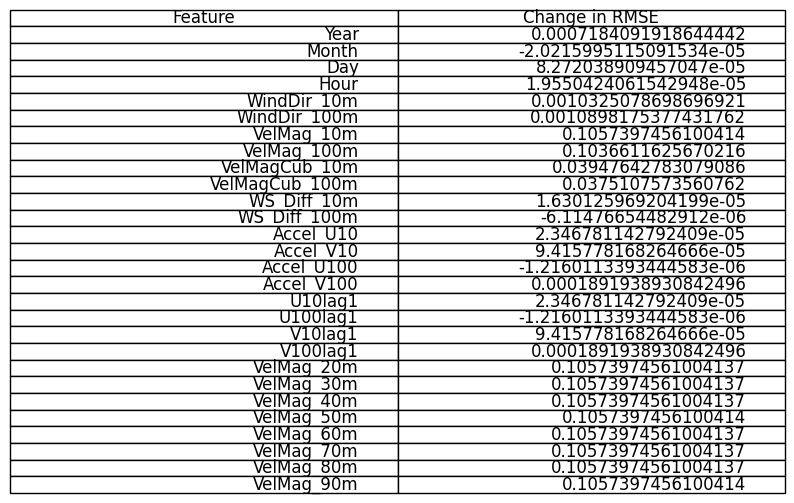

In [46]:
# Create a table showing feature and change in RMSE
plt.figure(figsize=(10, 6))
cell_text = [[feature, change] for feature, change in rmse_change.items()]

# Add the table to the plot
table = plt.table(cellText=cell_text, colLabels=['Feature', 'Change in RMSE'], loc='center')

# Set font size for table
table.auto_set_font_size(False)
table.set_fontsize(12)

# Remove axis
plt.axis('off')

# Show plot
plt.show()

In [47]:
#optimizing for best columns.
columns_to_keep = [feature for feature, change in rmse_change.items() if change >= 0]
TrainData_filtered = TrainData[columns_to_keep + ['U10', 'U100', 'V10', 'V100','POWER']] 
TrainData_test=TrainData_filtered.drop(columns=['POWER'])
X_train, X_test, y_train, y_test = train_test_split(TrainData_test, TrainData_filtered[target], test_size=0.2, random_state=42)
# Define a list of models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "Gradient Boosting Regression": GradientBoostingRegressor(),
    "SVR": SVR(),
    "CatBoost Regression": CatBoostRegressor()  # Adding CatBoostRegressor
}

# Create an empty dictionary to store RMSE for each model
rmse_results = {}

# Iterate through each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store RMSE in the results dictionary
    rmse_results[model_name] = rmse

# Print RMSE for each model
for model_name, rmse in rmse_results.items():
    print(f"RMSE for {model_name}: {rmse}")

Learning rate set to 0.066807
0:	learn: 0.2956714	total: 4.33ms	remaining: 4.33s
1:	learn: 0.2809215	total: 7.81ms	remaining: 3.9s
2:	learn: 0.2675192	total: 11.8ms	remaining: 3.93s
3:	learn: 0.2551039	total: 15.4ms	remaining: 3.85s
4:	learn: 0.2439897	total: 19ms	remaining: 3.78s
5:	learn: 0.2336198	total: 22.5ms	remaining: 3.73s
6:	learn: 0.2239198	total: 25.8ms	remaining: 3.65s
7:	learn: 0.2149704	total: 29.2ms	remaining: 3.62s
8:	learn: 0.2068869	total: 33.3ms	remaining: 3.66s
9:	learn: 0.1992871	total: 37ms	remaining: 3.67s
10:	learn: 0.1924097	total: 40.1ms	remaining: 3.6s
11:	learn: 0.1863425	total: 43.3ms	remaining: 3.56s
12:	learn: 0.1805591	total: 46.8ms	remaining: 3.55s
13:	learn: 0.1754243	total: 49.8ms	remaining: 3.51s
14:	learn: 0.1706698	total: 53ms	remaining: 3.48s
15:	learn: 0.1664754	total: 56.2ms	remaining: 3.46s
16:	learn: 0.1625149	total: 59.3ms	remaining: 3.43s
17:	learn: 0.1589772	total: 62.3ms	remaining: 3.4s
18:	learn: 0.1557639	total: 65.3ms	remaining: 3.37s
1

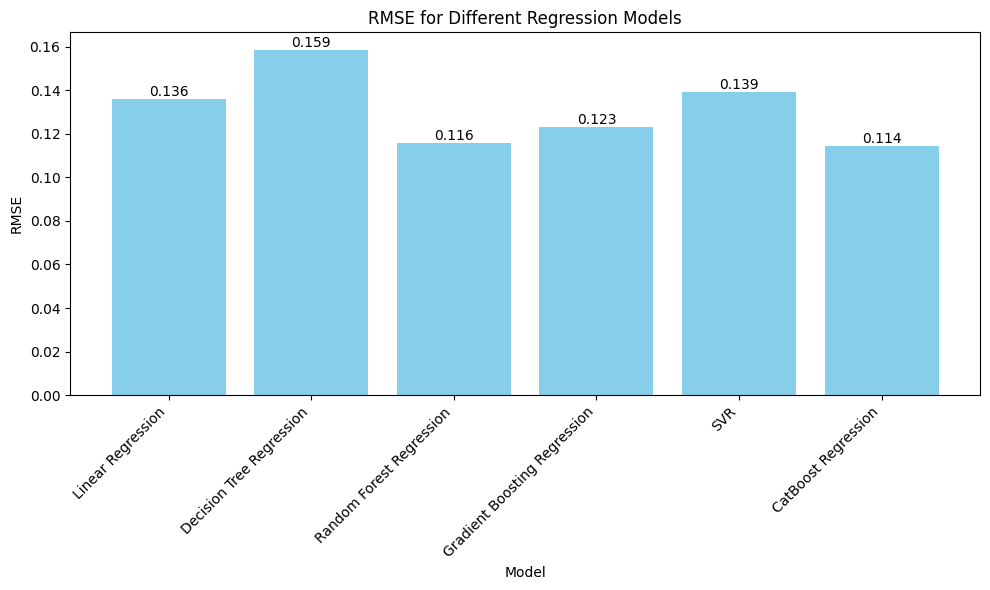

In [48]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(rmse_results.keys(), rmse_results.values(), color='skyblue')

# Adding RMSE values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center')

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE for Different Regression Models')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


## Determining Best Model 

In [49]:

# Find the model with the lowest RMSE
best_model_name = min(rmse_results, key=rmse_results.get)
best_model = models[best_model_name]
X_train, X_test, y_train, y_test = train_test_split(TrainData_test, TrainData_filtered[target], test_size=0.000001, random_state=42)
# Train the best model again
best_model.fit(X_train, y_train)

# Make predictions
y_pred_best = best_model.predict(X_test)

# Calculate RMSE for the best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"RMSE for the best model ({best_model_name}): {rmse_best}")


Learning rate set to 0.069204
0:	learn: 0.2952801	total: 4.66ms	remaining: 4.66s
1:	learn: 0.2801291	total: 8.52ms	remaining: 4.25s
2:	learn: 0.2660932	total: 12.4ms	remaining: 4.14s
3:	learn: 0.2532804	total: 16.4ms	remaining: 4.08s
4:	learn: 0.2419860	total: 21.1ms	remaining: 4.21s
5:	learn: 0.2312633	total: 25.6ms	remaining: 4.24s
6:	learn: 0.2214290	total: 29.6ms	remaining: 4.2s
7:	learn: 0.2124283	total: 33.8ms	remaining: 4.19s
8:	learn: 0.2040877	total: 37.2ms	remaining: 4.09s
9:	learn: 0.1965094	total: 40.4ms	remaining: 4s
10:	learn: 0.1896870	total: 43.4ms	remaining: 3.9s
11:	learn: 0.1836229	total: 46.4ms	remaining: 3.82s
12:	learn: 0.1780164	total: 49.5ms	remaining: 3.76s
13:	learn: 0.1728451	total: 52.6ms	remaining: 3.7s
14:	learn: 0.1680981	total: 55.7ms	remaining: 3.66s
15:	learn: 0.1637708	total: 58.9ms	remaining: 3.62s
16:	learn: 0.1599637	total: 62.3ms	remaining: 3.6s
17:	learn: 0.1565105	total: 65.6ms	remaining: 3.58s
18:	learn: 0.1534959	total: 68.8ms	remaining: 3.55s

## Testing Model 

In [50]:
# Load the CSV file
WeatherForecastInput = pd.read_csv("WeatherForecastInput_A.csv")
#apply all the features done previously on this file (adding features etc.)
WeatherForecastInput_test = convert_timestamp(WeatherForecastInput)
WeatherForecastInput_test = calculate_wind_direction(WeatherForecastInput_test)
WeatherForecastInput_test = calculate_velocity_magnitude(WeatherForecastInput_test)
WeatherForecastInput_test = add_cubic_power(WeatherForecastInput_test)
WeatherForecastInput_test = add_wind_speed_difference(WeatherForecastInput_test)
WeatherForecastInput_test = add_acceleration(WeatherForecastInput_test)
#WeatherForecastInputWeatherForecastInput= add_lag(WeatherForecastInput)
WeatherForecastInput_test = calculate_velocity_at_heights(WeatherForecastInput_test)
WeatherForecastInput_test= add_lag(WeatherForecastInput_test)
WeatherForecastInput_test = WeatherForecastInput_test[columns_to_keep + ['U10', 'U100', 'V10', 'V100']] 

WeatherForecastInput_test = WeatherForecastInput_test[columns_to_keep + ['U10', 'U100', 'V10', 'V100']] 
WeatherForecastInput_test.dropna(inplace=True)

# Make predictions
power_predictions = model.predict(WeatherForecastInput_test)

C:\Users\jihad\AppData\Local\Temp\ipykernel_14304\1713920562.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Accel_U10'].iloc[0] = df['Accel_U10'].iloc[1]
C:\Users\jihad\AppData\Local\Temp\ipykernel_14304\1713920562.py:30: SettingWi

In [51]:
# Create a new DataFrame with 'TIMESTAMP' and 'power_predictions' as columns
predicted_power_df= pd.DataFrame({'TIMESTAMP': WeatherForecastInput['TIMESTAMP'], 'power_predictions': power_predictions})

# Print the result DataFrame
print(predicted_power_df)


          TIMESTAMP  power_predictions
1    20180201 02:00           0.861929
2    20180201 03:00           0.815584
3    20180201 04:00           0.805371
4    20180201 05:00           0.805143
5    20180201 06:00           0.815943
..              ...                ...
667  20180228 20:00           0.680629
668  20180228 21:00           0.757172
669  20180228 22:00           0.745815
670  20180228 23:00           0.721494
671  20180301 00:00           0.770805

[671 rows x 2 columns]


In [52]:
# Load the CSV file with the Solution
true_power_df = pd.read_csv('Solution_A.csv')

# Convert 'TIMESTAMP' column to datetime if needed
true_power_df['TIMESTAMP'] = pd.to_datetime(true_power_df['TIMESTAMP'])
# Convert 'TIMESTAMP' column to datetime in the DataFrame containing predicted power values
predicted_power_df['TIMESTAMP'] = pd.to_datetime(predicted_power_df['TIMESTAMP'])

# Merge predicted power values with true power values based on TIMESTAMP
merged_df = pd.merge(true_power_df, predicted_power_df, on='TIMESTAMP', suffixes=('_true', '_predicted'))

# Calculate the absolute difference between true and predicted power values
merged_df['Power_Difference'] = abs(merged_df['POWER'] - merged_df['power_predictions'])

# Print the merged DataFrame with the power difference
print(merged_df)

              TIMESTAMP     POWER  power_predictions  Power_Difference
0   2018-02-01 02:00:00  0.921515           0.861929          0.059586
1   2018-02-01 03:00:00  0.895380           0.815584          0.079795
2   2018-02-01 04:00:00  0.898016           0.805371          0.092645
3   2018-02-01 05:00:00  0.862974           0.805143          0.057831
4   2018-02-01 06:00:00  0.846178           0.815943          0.030235
..                  ...       ...                ...               ...
666 2018-02-28 20:00:00  0.666377           0.680629          0.014252
667 2018-02-28 21:00:00  0.665494           0.757172          0.091678
668 2018-02-28 22:00:00  0.740842           0.745815          0.004973
669 2018-02-28 23:00:00  0.699803           0.721494          0.021691
670 2018-03-01 00:00:00  0.710395           0.770805          0.060410

[671 rows x 4 columns]


In [56]:
# Calculate the mean squared error for our predictions with respect to the Dataframe
mse = mean_squared_error(merged_df['POWER'], merged_df['power_predictions'])

# Calculate the RMSE (square root of the mean squared error)
rmse = np.sqrt(mse)

print("RMSE:", rmse)


RMSE: 0.07380993366147873


## Writing Forecast CSV FILe

In [59]:
# Specify the file path
file_path = 'Forecast_A.csv.csv'

predicted_power_df = predicted_power_df.rename(columns={"TIMESTAMP" :"TIMESTAMP","power_predictions" :"FORECAST"})

# Convert TIMESTAMP column to datetime object
predicted_power_df['TIMESTAMP'] = pd.to_datetime(predicted_power_df['TIMESTAMP'])

# Format TIMESTAMP column to desired format
predicted_power_df['TIMESTAMP'] = predicted_power_df['TIMESTAMP'].dt.strftime('%Y%m%d %H:%M')


predicted_power_df.to_csv(file_path, index=False)

print("Excel file has been created successfully!")

Excel file has been created successfully!


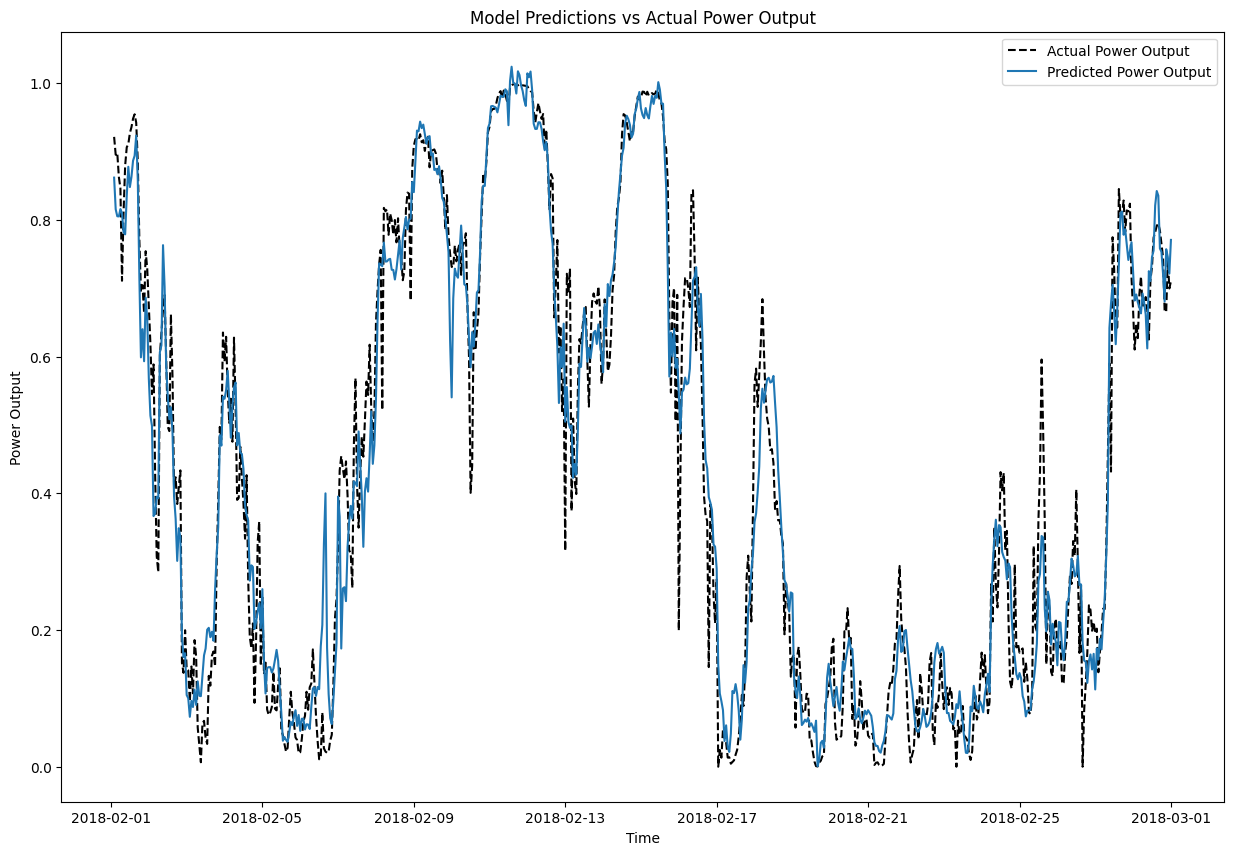

In [60]:
# Visualization of predictions vs actual values
plt.figure(figsize=(15, 10))
plt.plot(merged_df['TIMESTAMP'], merged_df['POWER'], label='Actual Power Output', color='black', linestyle='--')
plt.plot(merged_df['TIMESTAMP'], merged_df['power_predictions'], label='Predicted Power Output')
plt.title('Model Predictions vs Actual Power Output')
plt.xlabel('Time')
plt.ylabel('Power Output')
plt.legend()
plt.show()

In [61]:
predicted_power_df


,TIMESTAMP,FORECAST
1,20180201 02:00,0.861929
2,20180201 03:00,0.815584
3,20180201 04:00,0.805371
4,20180201 05:00,0.805143
5,20180201 06:00,0.815943
...,...,...
667,20180228 20:00,0.680629
668,20180228 21:00,0.757172
669,20180228 22:00,0.745815
670,20180228 23:00,0.721494
